In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.utils.Contact_Matrix import create_contact_matrix

In [ ]:
def extract_behavior_distribution(df, behavior_type):
    """
    Extract behavior distribution from survey data.
    
    Args:
        df: DataFrame with survey data
        behavior_type: Type of behavior ("masks", "testing", or "vacc")
        
    Returns:
        Normalized behavior distribution as a numpy array
    """
    # Clean data
    df = df.dropna()
    
    # Extract self-reported behavior
    self_behavior = df[f'{behavior_type}_self'].astype(int)
    
    # Count occurrences of each behavior level (1-5)
    n_bins = 5
    behavior_vector = np.zeros(n_bins)
    for i in range(n_bins):
        behavior_vector[i] = np.sum(self_behavior == i+1)
    
    # Normalize to get distribution
    behavior_vector = behavior_vector / np.sum(behavior_vector)
    
    return behavior_vector


In [ ]:
def bootstrap_behavior_distribution(df, behavior_type, n_bootstrap=1000, random_state=None):
    """
    Perform bootstrap analysis on behavior distribution to estimate mean and polarization.
    
    Args:
        df: DataFrame with survey data
        behavior_type: Type of behavior ("masks", "testing", or "vacc")
        n_bootstrap: Number of bootstrap samples
        random_state: Random seed for reproducibility
        
    Returns:
        Dictionary with bootstrap results
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Get clean dataset with no NAs in the target behavior
    df_clean = df.dropna(subset=[f'{behavior_type}_self'])
    n_samples = len(df_clean)
    
    # Arrays to store bootstrap results
    bootstrap_means = np.zeros(n_bootstrap)
    bootstrap_polarizations = np.zeros(n_bootstrap)
    
    # Perform bootstrap
    for i in tqdm(range(n_bootstrap), desc=f"Bootstrapping {behavior_type}"):
        # Sample with replacement
        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        bootstrap_sample = df_clean.iloc[bootstrap_indices]
        
        # Get self-reported behavior and rescale from 1-5 to 0-1
        self_behavior = bootstrap_sample[f'{behavior_type}_self'].astype(int)
        rescaled_behavior = (self_behavior - 1) / 4  # Rescale from 1-5 to 0-1
        
        # Calculate mean and polarization for this bootstrap sample
        bootstrap_means[i] = np.mean(rescaled_behavior)
        bootstrap_polarizations[i] = 4 * np.var(rescaled_behavior)  # Calculate polarization as 4*variance
        
    
    # Calculate summary statistics
    mean_estimate = np.mean(bootstrap_means)
    polarization_estimate = np.mean(bootstrap_polarizations)
    
    # Calculate 95% confidence intervals
    mean_ci = np.percentile(bootstrap_means, [2.5, 97.5])
    polarization_ci = np.percentile(bootstrap_polarizations, [2.5, 97.5])
    
    # Calculate standard errors
    mean_se = np.std(bootstrap_means)
    polarization_se = np.std(bootstrap_polarizations)
    
    return {
        'bootstrap_means': bootstrap_means,
        'bootstrap_polarizations': bootstrap_polarizations,
        'mean_estimate': mean_estimate,
        'mean_se': mean_se,
        'mean_ci': mean_ci,
        'polarization_estimate': polarization_estimate,
        'polarization_se': polarization_se,
        'polarization_ci': polarization_ci
    }


In [1]:
# Load data
csv_path = 'data_homophily.csv'
df = pd.read_csv(csv_path)

# Clean data (remove rows with missing values)
print(f"Number of rows before dropping NAs: {len(df)}")
df = df.dropna()
print(f"Number of rows after dropping NAs: {len(df)}")

NameError: name 'pd' is not defined

In [13]:
# Run bootstrap analysis for each behavior type
n_bootstrap = 1000  # Adjust based on computational resources
behavior_types = ["masks", "testing", "vacc"]
behavior_stats = {}

for behavior_type in behavior_types:
    behavior_stats[behavior_type] = bootstrap_behavior_distribution(
        df, 
        behavior_type, 
        n_bootstrap=n_bootstrap, 
        random_state=42
    )
    
    # Print results
    print(f"\n{behavior_type.capitalize()} behavior statistics:")
    print(f"Mean: {behavior_stats[behavior_type]['mean_estimate']:.4f} ± {behavior_stats[behavior_type]['mean_se']:.4f}")
    print(f"Polarization: {behavior_stats[behavior_type]['polarization_estimate']:.4f} ± {behavior_stats[behavior_type]['polarization_se']:.4f}")

Bootstrapping masks: 100%|██████████| 1000/1000 [00:00<00:00, 1272.89it/s]



Masks behavior statistics:
Mean: 0.7717 ± 0.0071
Polarization: 0.2785 ± 0.0130


Bootstrapping testing: 100%|██████████| 1000/1000 [00:00<00:00, 1338.34it/s]



Testing behavior statistics:
Mean: 0.4699 ± 0.0093
Polarization: 0.4802 ± 0.0110


Bootstrapping vacc: 100%|██████████| 1000/1000 [00:00<00:00, 1471.18it/s]


Vacc behavior statistics:
Mean: 0.6133 ± 0.0104
Polarization: 0.5725 ± 0.0135


In [16]:
# Estimate homophily for each behavior type
homophily_stats = {}

for behavior_type in behavior_types:
    homophily_stats[behavior_type] = bootstrap_homophily(
        df, 
        behavior_type, 
        n_bootstrap=1000,  # Adjust based on computational resources
        h_min=0, 
        h_max=4, 
        random_state=42
    )
    
    # Print results
    print(f"\n{behavior_type.capitalize()} homophily statistics:")
    print(f"Homophily: {homophily_stats[behavior_type]['mean']:.4f} ± {homophily_stats[behavior_type]['se']:.4f}")
    print(f"95% CI: [{homophily_stats[behavior_type]['ci'][0]:.4f}, {homophily_stats[behavior_type]['ci'][1]:.4f}]")

Bootstrapping homophily for masks: 100%|██████████| 1000/1000 [00:00<00:00, 1020.66it/s]



Masks homophily statistics:
Homophily: 1.9624 ± 0.0396
95% CI: [1.8990, 2.0202]


Bootstrapping homophily for testing: 100%|██████████| 1000/1000 [00:00<00:00, 1195.80it/s]



Testing homophily statistics:
Homophily: 0.4813 ± 0.0178
95% CI: [0.4444, 0.5253]


Bootstrapping homophily for vacc: 100%|██████████| 1000/1000 [00:00<00:00, 1174.06it/s]


Vacc homophily statistics:
Homophily: 0.4967 ± 0.0204
95% CI: [0.4848, 0.5253]


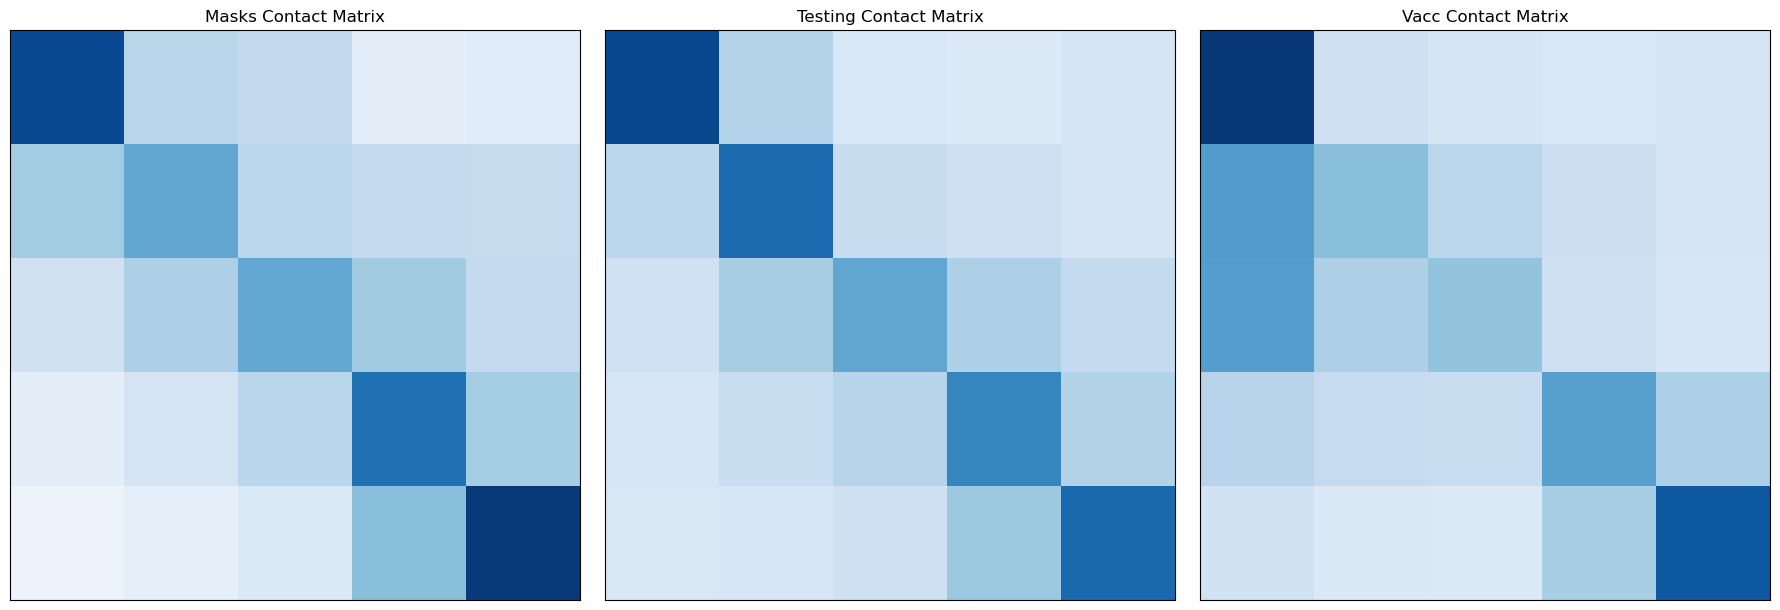

In [11]:
# Generate normalized contact matrices
contact_matrices = {}
for behavior_type in behavior_types:
    contact_matrices[behavior_type] = generate_normalized_matrix(df, behavior_type)

# Visualize contact matrices
plt.figure(figsize=(18, 6))

for i, behavior_type in enumerate(behavior_types):
    plt.subplot(1, 3, i+1)
    plt.imshow(contact_matrices[behavior_type], cmap="Blues", vmin=0, vmax=0.6)
    plt.title(f"{behavior_type.capitalize()} Contact Matrix")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

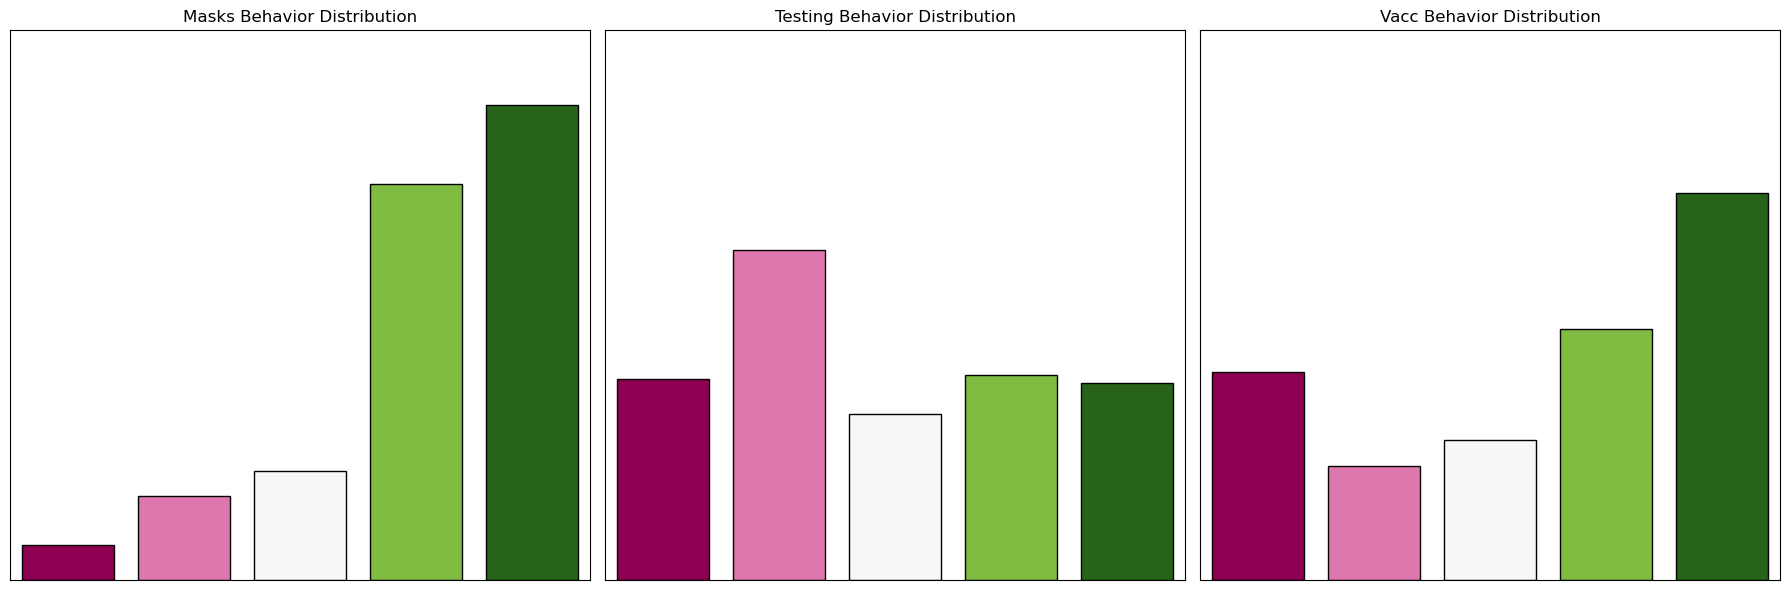

In [12]:
# Define colors for behavior levels
intensity_colors = ['#8E0152', '#DE77AE', '#F7F7F7', '#7FBC41', '#276419']

# Visualize behavior distributions
plt.figure(figsize=(18, 6))

for i, behavior_type in enumerate(behavior_types):
    plt.subplot(1, 3, i+1)
    
    # Get behavior distribution
    distribution = extract_behavior_distribution(df, behavior_type)
    
    # Plot distribution
    for j in range(5):
        plt.bar(j+1, distribution[j], color=intensity_colors[j], edgecolor='black')
    
    plt.title(f"{behavior_type.capitalize()} Behavior Distribution")
    plt.xlim(0.5, 5.5)
    plt.ylim(0, 0.5)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

In [13]:
# Create summary table with all statistics
summary_data = {
    'Behavior': [],
    'Mean ± SE': [],
    'Polarization ± SE': [],
    'Homophily ± SE': []
}

for behavior_type in behavior_types:
    summary_data['Behavior'].append(behavior_type.capitalize())
    
    mean = behavior_stats[behavior_type]['mean_estimate']
    mean_se = behavior_stats[behavior_type]['mean_se']
    summary_data['Mean ± SE'].append(f"{mean:.4f} ± {mean_se:.4f}")
    
    pol = behavior_stats[behavior_type]['polarization_estimate']
    pol_se = behavior_stats[behavior_type]['polarization_se']
    summary_data['Polarization ± SE'].append(f"{pol:.4f} ± {pol_se:.4f}")
    
    hom = homophily_stats[behavior_type]['mean']
    hom_se = homophily_stats[behavior_type]['se']
    summary_data['Homophily ± SE'].append(f"{hom:.4f} ± {hom_se:.4f}")

# Convert to DataFrame and display
summary_df = pd.DataFrame(summary_data)
print(summary_df)

  Behavior        Mean ± SE Polarization ± SE     Homophily ± SE
0    Masks  0.7713 ± 0.0071   0.2786 ± 0.0128  40.9565 ± 14.4968
1  Testing  0.4699 ± 0.0094   0.4803 ± 0.0111   49.9763 ± 0.8383
2     Vacc  0.6129 ± 0.0103   0.5729 ± 0.0137   11.0943 ± 1.1541
